# Load Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle

# Load Dataset

In [ ]:
FILE_PATH = './data/sonnets.txt'
NUM_BATCHES = 16
LSTM_UNITS = 128
EMBEDDING_DIM = 100

In [ ]:
# Read the data
with open(FILE_PATH) as f:
    data = f.read()

# Convert to lower case and save as a list
corpus = data.lower().split("\n")

print(f"There are {len(corpus)} lines of sonnets\n")
print(f"The first 5 lines look like this:\n")
for i in range(5):
  print(corpus[i])

There are 2159 lines of sonnets

The first 5 lines look like this:

from fairest creatures we desire increase,
that thereby beauty's rose might never die,
but as the riper should by time decease,
his tender heir might bear his memory:
but thou, contracted to thine own bright eyes,


# fit_vectorizer

In [ ]:
def fit_vectorizer(corpus):
    """
    Instantiates the vectorizer class on the corpus

    Args:
        corpus (list): List with the sentences.

    Returns:
        (tf.keras.layers.TextVectorization): an instance of the TextVectorization class containing the word-index dictionary, adapted to the corpus sentences.
    """

    tf.keras.utils.set_random_seed(65) # Do not change this line or you may have different expected outputs throughout the assignment

    ### START CODE HERE ###
    # Create the vectorizer with ragged=True and custom standardization
    vectorizer = tf.keras.layers.TextVectorization(
        standardize='lower_and_strip_punctuation',
        ragged=True
    )

    # Adapt it to the corpus
    vectorizer.adapt(corpus)
    ### END CODE HERE ###


    return vectorizer

In [ ]:
vectorizer = fit_vectorizer(corpus)
total_words = len(vectorizer.get_vocabulary())
print(f"Total number of words in corpus (including the out of vocabulary): {total_words}")

Total number of words in corpus (including the out of vocabulary): 3189


In [ ]:
print(f"Passing a string directly: {vectorizer('This is a test string').__repr__()}")
print(f"Passing a list of strings: {vectorizer(['This is a test string'])}")

Passing a string directly: <tf.Tensor: shape=(5,), dtype=int64, numpy=array([  29,   14,   18,    1, 1679])>
Passing a list of strings: <tf.RaggedTensor [[29, 14, 18, 1, 1679]]>


# n_gram_seqs


In [ ]:
def n_gram_seqs(corpus, vectorizer):
    """
    Generates a list of n-gram sequences

    Args:
        corpus (list of string): lines of texts to generate n-grams for
        vectorizer (tf.keras.layers.TextVectorization): an instance of the TextVectorization class adapted in the corpus

    Returns:
        (list of tf.int64 tensors): the n-gram sequences for each line in the corpus
    """
    input_sequences = []

    ### START CODE HERE ###
    for sentence in corpus:
        # Convert the sentence to token indices
        token_indices = vectorizer(sentence)

        # Generate n-grams by iterating through the tokens
        for i in range(1, len(token_indices)):
            # Take the first i+1 tokens as n-gram sequence
            n_gram_seq = token_indices[:i+1]
            input_sequences.append(n_gram_seq)
    ### END CODE HERE ###

    return input_sequences

In [ ]:
# Test your function with one example
first_example_sequence = n_gram_seqs([corpus[0]], vectorizer)

print("n_gram sequences for first example look like this:\n")
first_example_sequence

n_gram sequences for first example look like this:



[<tf.Tensor: shape=(2,), dtype=int64, numpy=array([ 35, 489])>,
 <tf.Tensor: shape=(3,), dtype=int64, numpy=array([  35,  489, 1259])>,
 <tf.Tensor: shape=(4,), dtype=int64, numpy=array([  35,  489, 1259,  164])>,
 <tf.Tensor: shape=(5,), dtype=int64, numpy=array([  35,  489, 1259,  164,  230])>,
 <tf.Tensor: shape=(6,), dtype=int64, numpy=array([  35,  489, 1259,  164,  230,  582])>]

In [ ]:
# Test your function with a bigger corpus
next_3_examples_sequence = n_gram_seqs(corpus[1:4], vectorizer)

print("n_gram sequences for next 3 examples look like this:\n")
next_3_examples_sequence

n_gram sequences for next 3 examples look like this:



[<tf.Tensor: shape=(2,), dtype=int64, numpy=array([  9, 935])>,
 <tf.Tensor: shape=(3,), dtype=int64, numpy=array([  9, 935, 143])>,
 <tf.Tensor: shape=(4,), dtype=int64, numpy=array([  9, 935, 143, 369])>,
 <tf.Tensor: shape=(5,), dtype=int64, numpy=array([  9, 935, 143, 369, 101])>,
 <tf.Tensor: shape=(6,), dtype=int64, numpy=array([  9, 935, 143, 369, 101, 171])>,
 <tf.Tensor: shape=(7,), dtype=int64, numpy=array([  9, 935, 143, 369, 101, 171, 207])>,
 <tf.Tensor: shape=(2,), dtype=int64, numpy=array([17, 23])>,
 <tf.Tensor: shape=(3,), dtype=int64, numpy=array([17, 23,  3])>,
 <tf.Tensor: shape=(4,), dtype=int64, numpy=array([  17,   23,    3, 1006])>,
 <tf.Tensor: shape=(5,), dtype=int64, numpy=array([  17,   23,    3, 1006,   64])>,
 <tf.Tensor: shape=(6,), dtype=int64, numpy=array([  17,   23,    3, 1006,   64,   31])>,
 <tf.Tensor: shape=(7,), dtype=int64, numpy=array([  17,   23,    3, 1006,   64,   31,   51])>,
 <tf.Tensor: shape=(8,), dtype=int64, numpy=array([  17,   23,   

In [ ]:
# Apply the n_gram_seqs transformation to the whole corpus
input_sequences = n_gram_seqs(corpus, vectorizer)

# Save max length
max_sequence_len = max([len(x) for x in input_sequences])

print(f"n_grams of input_sequences have length: {len(input_sequences)}")
print(f"maximum length of sequences is: {max_sequence_len}")

n_grams of input_sequences have length: 15355
maximum length of sequences is: 11


# pad_seqs


In [ ]:
def pad_seqs(input_sequences, max_sequence_len):
    """
    Pads tokenized sequences to the same length

    Args:
        input_sequences (list of int): tokenized sequences to pad
        maxlen (int): maximum length of the token sequences

    Returns:
        (np.array of int32): tokenized sequences padded to the same length
    """

    ### START CODE HERE ###
    padded_sequences = tf.keras.utils.pad_sequences(
        input_sequences,
        maxlen=max_sequence_len,
        padding='pre'
    )
    ### END CODE HERE ###

    return padded_sequences

In [ ]:
# Test your function with the n_grams_seq of the first example
first_padded_seq = pad_seqs(first_example_sequence, max([len(x) for x in first_example_sequence]))
first_padded_seq

array([[   0,    0,    0,    0,   35,  489],
       [   0,    0,    0,   35,  489, 1259],
       [   0,    0,   35,  489, 1259,  164],
       [   0,   35,  489, 1259,  164,  230],
       [  35,  489, 1259,  164,  230,  582]], dtype=int32)

In [ ]:
# Test your function with the n_grams_seq of the next 3 examples
next_3_padded_seq = pad_seqs(next_3_examples_sequence, max([len(s) for s in next_3_examples_sequence]))
next_3_padded_seq

array([[   0,    0,    0,    0,    0,    0,    9,  935],
       [   0,    0,    0,    0,    0,    9,  935,  143],
       [   0,    0,    0,    0,    9,  935,  143,  369],
       [   0,    0,    0,    9,  935,  143,  369,  101],
       [   0,    0,    9,  935,  143,  369,  101,  171],
       [   0,    9,  935,  143,  369,  101,  171,  207],
       [   0,    0,    0,    0,    0,    0,   17,   23],
       [   0,    0,    0,    0,    0,   17,   23,    3],
       [   0,    0,    0,    0,   17,   23,    3, 1006],
       [   0,    0,    0,   17,   23,    3, 1006,   64],
       [   0,    0,   17,   23,    3, 1006,   64,   31],
       [   0,   17,   23,    3, 1006,   64,   31,   51],
       [  17,   23,    3, 1006,   64,   31,   51,  803],
       [   0,    0,    0,    0,    0,    0,   27,  315],
       [   0,    0,    0,    0,    0,   27,  315,  745],
       [   0,    0,    0,    0,   27,  315,  745,  101],
       [   0,    0,    0,   27,  315,  745,  101,  209],
       [   0,    0,   27,  315,

In [ ]:
# Pad the whole corpus
input_sequences = pad_seqs(input_sequences, max_sequence_len)

print(f"padded corpus has shape: {input_sequences.shape}")

padded corpus has shape: (15355, 11)


# features_and_labels

In [ ]:
def features_and_labels_dataset(input_sequences, total_words):
    """
    Generates features and labels from n-grams and returns a tensorflow dataset

    Args:
        input_sequences (list of int): sequences to split features and labels from
        total_words (int): vocabulary size

    Returns:
        (tf.data.Dataset): Dataset with elements in the form (sentence, label)
    """
    ### START CODE HERE ###
    # Define the features and labels
    features = [sequence[:-1] for sequence in input_sequences]
    labels = [sequence[-1] for sequence in input_sequences]

    # One hot encode the labels
    one_hot_labels = tf.keras.utils.to_categorical(labels, num_classes=total_words)

    # Build the dataset with the features and one hot encoded labels
    dataset = tf.data.Dataset.from_tensor_slices((features, one_hot_labels))

    # Batch the dataset. Define batch_size here.
    batch_size = 32 # You can choose an appropriate batch size
    batched_dataset = dataset.batch(batch_size)
    ### END CODE HERE ###

    return batched_dataset

In [ ]:
# Test your function with the padded n_grams_seq of the first example
dataset_example = features_and_labels_dataset(first_padded_seq, total_words)

print("Example:\n")
for features, label in dataset_example.take(1):
    print(f"N grams:\n\n {features}\n")
    print(f"Label shape:\n\n {label.shape}")

Example:

N grams:

 [[   0    0    0    0   35]
 [   0    0    0   35  489]
 [   0    0   35  489 1259]
 [   0   35  489 1259  164]
 [  35  489 1259  164  230]]

Label shape:

 (5, 3189)


In [ ]:
# Split the whole corpus
dataset = features_and_labels_dataset(input_sequences, total_words).prefetch(tf.data.AUTOTUNE)

print(f"Feature shape: {dataset.element_spec[0]}")
print(f"Label shape: {dataset.element_spec[1]}")

Feature shape: TensorSpec(shape=(None, 10), dtype=tf.int32, name=None)
Label shape: TensorSpec(shape=(None, 3189), dtype=tf.float64, name=None)


# Model Training

In [ ]:
def create_model(total_words, max_sequence_len):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(max_sequence_len,)),
        tf.keras.layers.Embedding(total_words, 200),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200)),
        tf.keras.layers.Dense(total_words, activation='softmax')
    ])

    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )

    return model


In [ ]:
# Get the untrained model
model = create_model(total_words, max_sequence_len)

# Check the parameter count against a reference solution
unittests.parameter_count(model)

Your model has 2,558,189 total parameters and the reference is 2,000,000
Warning! this exceeds the reference which is 2,000,000. If the kernel crashes while training, switch to a simpler architecture.

Your model has 2,558,189 trainable parameters and the reference is 2,000,000
Warning! this exceeds the reference which is 2,000,000. If the kernel crashes while training, switch to a simpler architecture.


In [ ]:
example_batch = dataset.take(1)

try:
	model.evaluate(example_batch, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function and last layer are compatible with one another.")
else:
	predictions = model.predict(example_batch, verbose=False)
	print(f"predictions have shape: {predictions.shape}")

predictions have shape: (32, 3189)


In [ ]:
# Train the model
history = model.fit(dataset, epochs=30, verbose=1)

Epoch 1/30
480/480 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.0248 - loss: 7.0678
Epoch 2/30
480/480 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.0270 - loss: 6.2331
Epoch 3/30
480/480 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.0398 - loss: 5.8665
Epoch 4/30
480/480 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.0506 - loss: 5.5417
Epoch 5/30
480/480 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.0631 - loss: 5.2975
Epoch 6/30
480/480 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.0771 - loss: 5.0759
Epoch 7/30
480/480 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.0870 - loss: 4.8173
Epoch 8/30
480/480 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1084 - loss: 4.5005
Epoch 9/30
480/480 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1496 - loss: 4.2269
Epoch 10/30
480/480 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.2068 - loss: 3.8390
Epoch 11/30
480/480 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.2138 - loss: 3.8441
Epoch 12/30
480/480 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

The model gives 87% accuracy

# Visualization

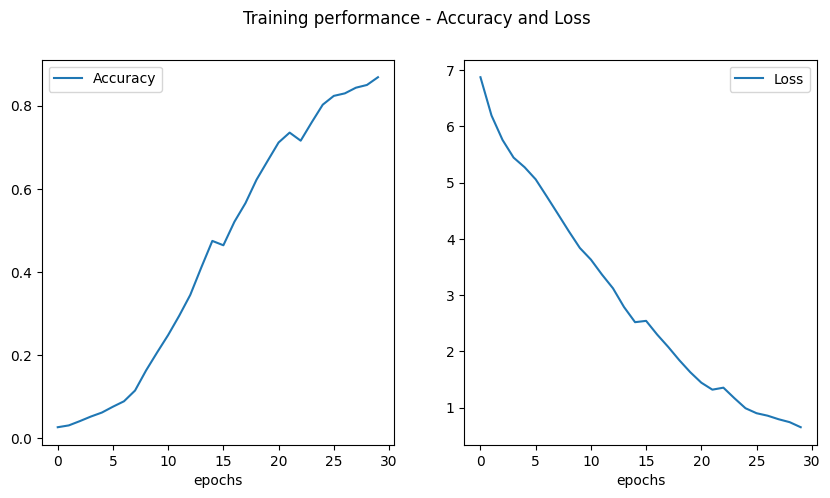

In [ ]:
# Get training and validation accuracies
acc = history.history['accuracy']
loss = history.history['loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training performance - Accuracy and Loss')

for i, (data, label) in enumerate(zip([acc,loss], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data, label=label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

# Predicting next words from the seed text

In [ ]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100

for _ in range(next_words):
    # Convert the text into sequences
    token_list = vectorizer(seed_text)
    # Pad the sequences
    token_list = tf.keras.utils.pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    # Get the probabilities of predicting a word
    predicted = model.predict([token_list], verbose=0)
    # Choose the next word based on the maximum probability
    predicted = np.argmax(predicted, axis=-1).item()
    # Get the actual word from the word index
    output_word = vectorizer.get_vocabulary()[predicted]
    # Append to the current text
    seed_text += " " + output_word

print(seed_text)

Help me Obi Wan Kenobi, you're my only hope of mind ill near slain prove thee best i have seen grow of pleasure thine age shall lie thou art as her old near near slain so ill near slain so short a lease of me love to me so near slain both me prove me ill near slain me love thee of yore hate on thee now i have ranged thee shame nor they see thee behold and prove thee me so true i am gone after you hold me so thou art all my art of thine eye will bear thee wrong friend pleasure new and me me
